In [85]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import GroupKFold
from sklearn.metrics import  mean_squared_log_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from scikitplot.estimators import plot_learning_curve

import xgboost as xgb

from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
df = pd.read_csv('/Users/patrycjapiechowicz/Downloads/bike.train.csv')
df.shape

(10886, 12)

In [181]:
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(' ', '')
              .str.replace('(', '')
              .str.replace(')', '')
              .str.replace('.', ''))

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [183]:
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [184]:
df[df['casual'] + train['registered'] != train['count']].shape

(0, 12)

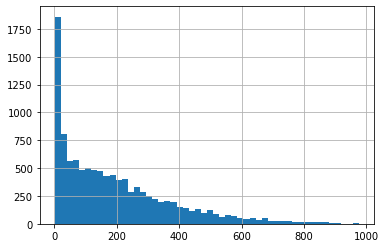

In [185]:
df['count'].hist(bins=50);

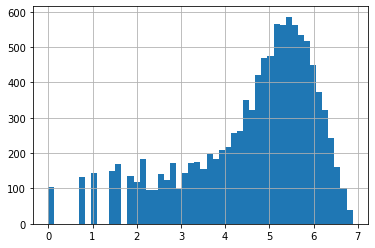

In [186]:
np.log(df['count']).hist(bins=50);

### Basic Model

In [187]:
X = df[ ['season'] ].values
y = df['count'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mean_squared_log_error(y, y_pred)

2.4623833108352082

In [188]:
np.sqrt(mean_squared_log_error(y, y_pred)) #workaround for rmsle

1.5691983019475926

### Feature Engineering

In [189]:
df['datetime'] = pd.to_datetime( df['datetime'] )

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

df['dayofweek'] = df['datetime'].dt.dayofweek
df['weekofyear'] = df['datetime'].dt.weekofyear
df['weekend'] = df['dayofweek'].map(lambda x: int(x in [5,6]) )
df['dayofyear'] = df['datetime'].dt.dayofyear

### Validation

In [190]:
def get_feats(df):
    black_list = ['count', 'registered', 'casual']
    feats = df.select_dtypes(include=[np.number]).columns
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats

def custom_validation(df, feats, target_variable='count', n_folds=3):
    X = df[feats].values
    y = df[target_variable].values

    groups = df['month'].values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        
def run_cv(df, feats, model, folds=3):
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(train, feats):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = rmsle(y_test, y_pred)

        scores.append(score)
        
    return np.mean(scores), np.std(scores)

In [191]:
get_feats(df)

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'dayofweek',
 'weekofyear',
 'weekend',
 'dayofyear']

In [192]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'dayofweek', 'weekofyear',
       'weekend', 'dayofyear'],
      dtype='object')

In [193]:
run_cv(df, get_feats(df), DecisionTreeRegressor(max_depth=5, random_state=2019))

KeyError: "['dayofweek', 'weekofyear', 'hour', 'weekend', 'dayofyear', 'month', 'year', 'minute', 'day'] not in index"

In [195]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'dayofweek', 'weekofyear',
       'weekend', 'dayofyear'],
      dtype='object')